##Librerias

In [ ]:
! git clone https://github.com/palexandremello/goes-py.git

fatal: destination path 'goes-py' already exists and is not an empty directory.


In [ ]:
cd goes-py

/content/goes-py


In [ ]:
!python /content/goes-py/setup.py install

running install
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: SetuptoolsDeprecationWarning: setup.py install is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` directly.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based tools.

        See https://blog.ganssle.io/articles/2021/10/setup-py-deprecated.html for details.
        ********************************************************************************

!!
  self.initialize_options()
/usr/local/lib/python3.10/dist-packages/setuptools/_distutils/cmd.py:66: EasyInstallDeprecationWarning: easy_install command is deprecated.
!!

        ********************************************************************************
        Please avoid running ``setup.py`` and ``easy_install``.
        Instead, use pypa/build, pypa/installer, pypa/build or
        other standards-based t

In [ ]:
pip install cartopy

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.8/11.8 MB 33.1 MB/s eta 0:00:00


In [ ]:
!pip install boto3

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 143.1/143.1 kB 3.1 MB/s eta 0:00:00
  Attempting uninstall: urllib3
    Found existing installation: urllib3 2.0.4
    Uninstalling urllib3-2.0.4:
      Successfully uninstalled urllib3-2.0.4


In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import glob
import numpy as np
import matplotlib.pyplot as plt

import xarray as xr
import sys
from goespy.Downloader import ABI_Downloader
import goespy.checkData
import cartopy.crs as ccrs
import geopandas as gpd
from shapely.geometry import Polygon
import cartopy.feature as cfeature
from cartopy.img_transform import warp_array

In [ ]:
from datetime import datetime, timedelta
import pytz, time

##Ver Datos Descargados

In [ ]:
product_list=os.listdir('/content/drive/MyDrive/GOES_train/')

In [ ]:
prduct2=os.listdir('/content/drive/MyDrive/Goes16Data/LSTF/DataN/')

In [ ]:
producto3=os.listdir('/content/drive/MyDrive/Goes16Data/LSTF/DataTrain/Input')

##Cargar el siguiente codigo antes de comenzar con el procesamiento de guardar las imagenes

In [ ]:
utc = pytz.timezone('UTC') # UTC timezone
utcm5 = pytz.timezone('America/Lima')
PeruLimits_deg = [-85, -67.5, -20.5, 1.0]

#==================== Creating georeferenced variables ====================
import geopandas as gpd
from shapely.geometry import Polygon
import cartopy.feature as cfeature

# Add coastlines feature
coastlines_feature = cfeature.NaturalEarthFeature(
    category='physical',
    name='coastline',
    scale='50m',
    edgecolor='black',
    facecolor='none')

# Add country boundaries feature
countries_feature = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='50m',
    edgecolor='black',
    facecolor='none')

# Create the polygon representing the bounding box
peru_bbox = Polygon([(PeruLimits_deg[0], PeruLimits_deg[2]), (PeruLimits_deg[1], PeruLimits_deg[2]), (PeruLimits_deg[1], PeruLimits_deg[3]), (PeruLimits_deg[0], PeruLimits_deg[3])])
# gdf_countries = gpd.read_file("./Boundaries/ne_10m_admin_0_countries/ne_10m_admin_0_countries.shp")
gdf_maritime = gpd.read_file("/content/drive/MyDrive/Boundary/eez_v11.shp",mask=peru_bbox,encoding="utf-8")
gdf_states = gpd.read_file("/content/drive/MyDrive/Boundary/ne_10m_admin_1_states_provinces.shp",mask=peru_bbox)

# Filter the GeoDataFrame to keep only rows where adm1_code matches "PER"
gdf_peru_land = gdf_states[gdf_states["adm1_code"].str[:3] == "PER"]
gdf_peru_sea = gdf_maritime[gdf_maritime["TERRITORY1"] == "Peru"].iloc[[1]]

##Guadar las imagenes procesadas de solo la region de Peru

In [ ]:
for selected_product in list(product_list):
  if(not bool(np.where(file2=='data_{}_{}.npy'.format(selected_product.split('_s',1)[1].split('_e',1)[0],selected_product.split('2-',1)[1].split('-M',1)[0]))[0])):
    FilePath = os.path.join('/content/drive/MyDrive/GOES_train/',selected_product) #/content/drive/MyDrive/DataGoes/
    FullFilePath = FilePath
    import xarray as xr
    data = xr.open_dataset(FullFilePath, engine='h5netcdf')
    if ('lon' in data.coords) and ('lat' in data.coords): coords = "lonlat"
    elif ('x' in data.coords) and ('y' in data.coords): coords = "xy"
    varname = list(data.data_vars.keys())[0]
    ImgTime = data.t.values
    ImgTime = utc.localize(datetime.utcfromtimestamp(ImgTime.tolist()//10**9))
    minute = str(ImgTime.minute).zfill(2)
    str_ImgTime = ImgTime.strftime('%Y-%m-%d %H:%M %Z')

    spatial_res = data.attrs["spatial_resolution"].split()[0]
    spatial_res = float(re.findall('\d+',spatial_res)[0])

    LonCenter = data.geospatial_lat_lon_extent.geospatial_lon_center
    LatCenter = data.geospatial_lat_lon_extent.geospatial_lat_center
    LonLimits = np.array([data.geospatial_lat_lon_extent.geospatial_westbound_longitude, data.geospatial_lat_lon_extent.geospatial_eastbound_longitude])
    LatLimits = np.array([data.geospatial_lat_lon_extent.geospatial_southbound_latitude, data.geospatial_lat_lon_extent.geospatial_northbound_latitude])
    imgExtention = [LonLimits[0], LonLimits[1], LatLimits[0], LatLimits[1]]
    map_proj_ortho = ccrs.Orthographic(central_longitude=LonCenter, central_latitude=LatCenter), "Orthographic"
    map_proj_pc = ccrs.PlateCarree(), "PlateCarree projection"
    if (coords == "lonlat"):
        gproj = data['goes_lat_lon_projection']
        map_proj_geos = ccrs.Geostationary(
                      central_longitude=LonCenter,
                      satellite_height=data.nominal_satellite_height.values*1000,
                      sweep_axis='x',
                      globe=ccrs.Globe(ellipse='sphere', # 'sphere', 'WGS84'
                                  semimajor_axis=gproj.semi_major_axis,
                                  semiminor_axis=gproj.semi_minor_axis)), "Geostationary projection"
        map_proj_src = map_proj_pc
        map_proj_dst = map_proj_geos
    elif (coords == "xy"):
        gproj = data['goes_imager_projection']
        map_proj_geos = ccrs.Geostationary(
                        central_longitude=LonCenter,
                        satellite_height=data.nominal_satellite_height.values*1000,
                        sweep_axis=gproj.sweep_angle_axis,
                        globe=ccrs.Globe(ellipse='sphere', # 'sphere', 'WGS84'
                                        semimajor_axis=gproj.semi_major_axis,
                                        semiminor_axis=gproj.semi_minor_axis)), "Geostationary projection"
        map_proj_src = map_proj_geos
        map_proj_dst = map_proj_pc
    olddata= np.flip(data[varname].values,0)
    data_shape = (olddata.shape[0],olddata.shape[1])
    # data_shape = (400, 200)
    newdata, new_extent = warp_array(olddata, map_proj_dst[0], map_proj_src[0], target_res = data_shape, target_extent=PeruLimits_deg)
    lon1D = np.linspace(new_extent[0], new_extent[1], data_shape[0])
    lat1D = np.linspace(new_extent[2], new_extent[3], data_shape[1])
    lon2D, lat2D = np.meshgrid(lon1D, lat1D)
    np.save('/content/drive/MyDrive/Goes16Data/LSTF/DataN/data_{}_{}.npy'.format(FilePath.split('_s',1)[1].split('_e',1)[0],FilePath.split('2-',1)[1].split('-M',1)[0]), newdata)
    print('--------')





In [ ]:
d=np.load(os.path.join('/content/drive/MyDrive/Goes16Data/LSTF/DataN/',file2[1]))

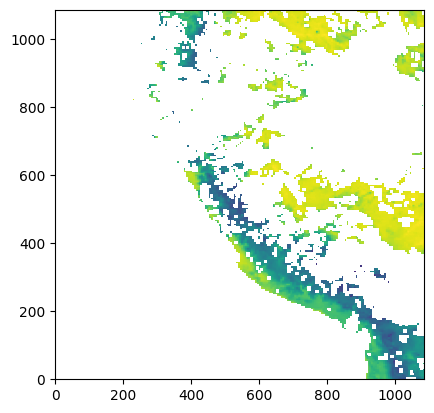

In [ ]:
plt.imshow(d, origin='lower')

In [ ]:
from matplotlib.colors import ListedColormap

In [ ]:
for FilePath in list(prduct2[:10]):
  if(not bool(np.where(producto3=='LSTF_{}.npz'.format(FilePath[5:14]))[0])):
    index= int(np.where(files ==FilePath)[0])
    FilePath4= prduct2[index+4]
    print(FilePath[5:14])
    a=datetime.strptime(FilePath[5:14],
                    '%Y%j%H')

    b=datetime.strptime(FilePath4[5:14],
                    '%Y%j%H')
    if ( (a+ timedelta(hours=4))==b):
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
        ax1.imshow(d1, origin='lower')
        ax1.set_title('Imagen{}'.format(a))
        ax2.imshow(d2, origin='lower')
        ax2.set_title('Imagen{}'.format(a + timedelta(hours=1)))
        ax3.imshow(d3, origin='lower')
        ax3.set_title('Imagen{}'.format(a+ timedelta(hours=2)))
        plt.show()

        fig2, (ax4, ax5) = plt.subplots(1, 2, figsize=(30,10))
        ax4.imshow(d4, origin='lower')
        ax4.set_title('Imagen{}'.format(a+ timedelta(hours=3)))
        ax5.imshow(d5, origin='lower')
        ax5.set_title('Imagen{}'.format(a + timedelta(hours=4)))
        plt.show()


##Creacion del DataSet para el entreneamiento de la RNN                                                                                                                                                                                                                                             

In [ ]:
N=[]
I=[]
files=np.array(prduct2)
list3=np.array(producto3)
for FilePath in list(prduct2):
  if(not bool(np.where(list3=='LSTF_{}.npz'.format(FilePath[5:14]))[0])):
    print(FilePath)
    index= int(np.where(files ==FilePath)[0])
    FilePath4= prduct2[index+4]

    a=datetime.strptime(FilePath[5:14],
                    '%Y%j%H')

    b=datetime.strptime(FilePath4[5:14],
                    '%Y%j%H')
    if ( (a+ timedelta(hours=4))==b):
      #input
      d1=np.load(os.path.join('/content/drive/MyDrive/Goes16Data/LSTF/DataN/',file2[index]))
      d2=np.load(os.path.join('/content/drive/MyDrive/Goes16Data/LSTF/DataN/',file2[index+1]))
      d3=np.load(os.path.join('/content/drive/MyDrive/Goes16Data/LSTF/DataN/',file2[index+2]))
      #output
      d4=np.load(os.path.join('/content/drive/MyDrive/Goes16Data/LSTF/DataN/',file2[index+3]))
      d5=np.load(os.path.join('/content/drive/MyDrive/Goes16Data/LSTF/DataN/',file2[index+4]))

      ran01=np.linspace(np.nanmin(d4),np.nanmax(d4),9)
      ran02=np.linspace(np.nanmin(d5),np.nanmax(d5),9)

      for i in range(8):
        np.putmask(d4, d4>ran01[7-i], 8-i)
        np.putmask(d5, d5>ran02[7-i], 8-i)

      input=[d1,d2,d3]
      output=[d4,d5]

      np.savez_compressed('/content/drive/MyDrive/Goes16Data/LSTF/DataTrain/Input/LSTF_{}.npz'.format(FilePath[5:14]), input)
      np.savez_compressed('/content/drive/MyDrive/Goes16Data/LSTF/DataTrain/output/LSTF_{}_mask.npz'.format(FilePath[5:14]), output)



    #fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
    #ax1.imshow(d1, origin='lower')
    #ax1.set_title('Imagen{}'.format(a))
    #ax2.imshow(d2, origin='lower')
    #ax2.set_title('Imagen{}'.format(a + timedelta(hours=1)))
    #ax3.imshow(d3, origin='lower')
    #ax3.set_title('Imagen{}'.format(a+ timedelta(hours=2)))
    #plt.show()

    #fig2, (ax4, ax5) = plt.subplots(1, 2, figsize=(30,10))
    #ax4.imshow(d4, origin='lower')
    #ax4.set_title('Imagen{}'.format(a+ timedelta(hours=3)))
    #ax5.imshow(d5, origin='lower')
    #ax5.set_title('Imagen{}'.format(a + timedelta(hours=4)))
    #plt.show()


##Vizualizar el dataset que sera entrenada

In [ ]:
for FilePath in list(producto3[1000:1011]):
  loadin = np.load('/content/drive/MyDrive/Goes16Data/LSTF/DataTrain/Input/{}'.format(FilePath))
  loadout=np.load('/content/drive/MyDrive/Goes16Data/LSTF/DataTrain/output/LSTF_{}_mask.npz'.format(FilePath[5:14]))

  d1=loadin['arr_0'][0]
  d2=loadin['arr_0'][1]
  d3=loadin['arr_0'][2]

  d4=loadout['arr_0'][0]
  d5=loadout['arr_0'][1]

  a=datetime.strptime(FilePath[5:14],
                    '%Y%j%H')

  fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(30,10))
  ax1.imshow(d1, origin='lower')
  ax1.set_title('Imagen{}'.format(a))
  ax2.imshow(d2, origin='lower')
  ax2.set_title('Imagen{}'.format(a + timedelta(hours=1)))
  ax3.imshow(d3, origin='lower')
  ax3.set_title('Imagen{}'.format(a+ timedelta(hours=2)))
  plt.show()

  fig2, (ax4, ax5) = plt.subplots(1, 2, figsize=(30,10))
 # ax4.imshow(d4, origin='lower')
  ax4.set_title('Imagen{}'.format(a+ timedelta(hours=3)))
  pcm1=ax4.pcolormesh(d4, cmap='RdBu_r',vmin=0, vmax=8)
  fig.colorbar(pcm1, ax= ax4, shrink=0.5)

  #ax5.imshow(d5, origin='lower')
  ax5.set_title('Imagen{}'.format(a + timedelta(hours=4)))
  pcm2=ax5.pcolormesh(d5,cmap='RdBu_r',vmin=0, vmax=8)
  fig.colorbar(pcm2, ax= ax5)

  plt.show()


##Librerias para el entrenamiento de la RNN UNET

In [ ]:
import cv2
import os
import glob
import numpy as np
from tqdm import tqdm
from skimage.io import imread, imshow
from skimage.transform import resize
import matplotlib.pyplot as plt
import datetime
import torch
import torch.nn.functional as F

In [ ]:
ruta_train='/content/drive/MyDrive/Goes16Data/LSTF/DataTrain/Input'
ruta_mask_train='/content/drive/MyDrive/Goes16Data/LSTF/DataTrain/output'
img_size=1000

##Cargar el DataSet y procesar antes que entre al RNN

In [ ]:
for FilePath in list(producto3):
  loadin = np.load('/content/drive/MyDrive/Goes16Data/LSTF/DataTrain/Input/{}'.format(FilePath))
  loadin=np.transpose(loadin['arr_0'], (1, 2, 0))
  img=cv2.cvtColor(loadin,cv2.COLOR_BGR2RGB)
  img = cv2.resize(img,(img_size,img_size))
  data_train.append([img])

  loadout = np.load('/content/drive/MyDrive/Goes16Data/LSTF/DataTrain/output/LSTF_{}_mask.npz'.format(FilePath[5:14]))
  loadout=loadout['arr_0'][0]
  img=loadout
  img = cv2.resize(img,(img_size,img_size))
  mask_oh = (np.arange(8) == img[...,None]).astype(np.float32)
  data_mask_train.append([mask_oh])

  gc.collect()

#  img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
#  ret,img = cv2.threshold(img,127,255,cv2.THRESH_BINARY)
#  np_array = np.array(img)/255

data_train = np.array(data_train)
Images_train = np.squeeze(np.array(data_train))
print(Images_train.shape)
data_mask_train = np.array(data_mask_train)
Images_mask_train = np.squeeze(np.array(data_mask_train))
#Images_mask_train = np.expand_dims(Images_mask_train, axis=-1)
print(Images_mask_train.shape)



  #img=cv2.resize(loadin['arr_0'],(img_size,img_size))

In [ ]:
data_train = np.array(data_train)
Images_train = np.squeeze(np.array(data_train))
print(Images_train.shape)

In [ ]:
Images_mask_train=torch.tensor(Images_mask_train)

###MODELO UNET

In [ ]:
import torch
import torch.nn.functional as F

def conv3x3_bn(ci, co):
    return torch.nn.Sequential(
        torch.nn.Conv2d(ci, co, 3, padding=1),
        torch.nn.BatchNorm2d(co),
        torch.nn.ReLU(inplace=True)
    )

def encoder_conv(ci, co):
  return torch.nn.Sequential(
        torch.nn.MaxPool2d(2),
        conv3x3_bn(ci, co),
        conv3x3_bn(co, co),
    )

class deconv(torch.nn.Module):
    def __init__(self, ci, co):
        super(deconv, self).__init__()
        self.upsample = torch.nn.ConvTranspose2d(ci, co, 2, stride=2)
        self.conv1 = conv3x3_bn(ci, co)
        self.conv2 = conv3x3_bn(co, co)

    # recibe la salida de la capa anetrior y la salida de la etapa
    # correspondiente del encoder
    def forward(self, x1, x2):
        x1 = self.upsample(x1)
        diffX = x2.size()[2] - x1.size()[2]
        diffY = x2.size()[3] - x1.size()[3]
        x1 = F.pad(x1, (diffX, 0, diffY, 0))
        # concatenamos los tensores
        x = torch.cat([x2, x1], dim=1)
        x = self.conv1(x)
        x = self.conv2(x)
        return x

class UNet(torch.nn.Module):
    def __init__(self, n_classes=8, in_ch=3):
        super().__init__()

        # lista de capas en encoder-decoder con número de filtros
        c = [16, 32, 64, 128]

        # primera capa conv que recibe la imagen
        self.conv1 = torch.nn.Sequential(
          conv3x3_bn(in_ch, c[0]),
          conv3x3_bn(c[0], c[0]),
        )
        # capas del encoder
        self.conv2 = encoder_conv(c[0], c[1])
        self.conv3 = encoder_conv(c[1], c[2])
        self.conv4 = encoder_conv(c[2], c[3])

        # capas del decoder
        self.deconv1 = deconv(c[3],c[2])
        self.deconv2 = deconv(c[2],c[1])
        self.deconv3 = deconv(c[1],c[0])

        # útlima capa conv que nos da la máscara
        self.out = torch.nn.Conv2d(c[0], n_classes, 3, padding=1)

    def forward(self, x):
        # encoder
        x1 = self.conv1(x)
        x2 = self.conv2(x1)
        x3 = self.conv3(x2)
        x = self.conv4(x3)
        # decoder
        x = self.deconv1(x, x3)
        x = self.deconv2(x, x2)
        x = self.deconv3(x, x1)
        x = self.out(x)
        return x

In [ ]:
model = UNet()
output = model(torch.randn((10,3,300,300)))
output.shape

torch.Size([10, 8, 300, 300])

In [ ]:
imgs = np.concatenate([Images_train])
masks= np.concatenate([Images_mask_train])

In [ ]:
def iou(outputs, labels):
    # aplicar sigmoid y convertir a binario
    outputs, labels = torch.sigmoid(outputs) > 0.5, labels > 0.5
    SMOOTH = 1e-6
    # BATCH x num_classes x H x W
    B, N, H, W = outputs.shape
    ious = []
    for i in range(N-1): # saltamos el background
        _out, _labs = outputs[:,i,:,:], labels[:,i,:,:]
        intersection = (_out & _labs).float().sum((1, 2))
        union = (_out | _labs).float().sum((1, 2))
        iou = (intersection + SMOOTH) / (union + SMOOTH)
        ious.append(iou.mean().item())
    return np.mean(ious)

In [ ]:
class Dataset(torch.utils.data.Dataset):
  def __init__(self, X, y, n_classes=8):
    self.X = X
    self.y = y
    self.n_classes = n_classes

  def __len__(self):
    return len(self.X)


  def __getitem__(self, ix):
    img = self.X[ix]
    mask = self.y[ix]
    return img ,mask

In [ ]:
NewMask=torch.tensor(masks).permute(0,3,1,2)
NewMask.shape

torch.Size([11, 8, 1000, 1000])

In [ ]:
NewImg=torch.tensor(imgs).permute(0,3,1,2)
NewImg.shape

torch.Size([11, 3, 1000, 1000])

In [ ]:
dataset = {
    'train': Dataset(NewImg[:5], NewMask[:5]),
    'test': Dataset(NewImg[5:], NewMask[5:])
}

len(dataset['train']), len(dataset['test'])

(5, 6)

In [ ]:
dataloader = {
    'train': torch.utils.data.DataLoader(dataset['train'], batch_size=16, shuffle=True, pin_memory=True),
    'test': torch.utils.data.DataLoader(dataset['test'], batch_size=8, pin_memory=True)
}

imgs, masks = next(iter(dataloader['train']))
imgs.shape, masks.shape

(torch.Size([5, 3, 1000, 1000]), torch.Size([5, 8, 1000, 1000]))

In [ ]:
from tqdm import tqdm

def fit(model, dataloader, epochs, lr=3e-4):
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)
    criterion = torch.nn.BCEWithLogitsLoss()
    model.to(device)
    hist = {'loss': [], 'iou': [], 'test_loss': [], 'test_iou': []}
    for epoch in range(1, epochs+1):
      bar = tqdm(dataloader['train'])
      train_loss, train_iou = [], []
      model.train()
      for imgs, masks in bar:
        imgs=imgs.float()
        masks=masks.float()
        imgs, masks = imgs.to(device), masks.to(device)
        optimizer.zero_grad()
        y_hat = model(imgs)
        loss = criterion(y_hat, masks)
        loss.backward()
        optimizer.step()
        ious = iou(y_hat, masks)
        train_loss.append(loss.item())
        train_iou.append(ious)
        bar.set_description(f"loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f}")
      hist['loss'].append(np.mean(train_loss))
      hist['iou'].append(np.mean(train_iou))
      bar = tqdm(dataloader['test'])
      test_loss, test_iou = [], []
      model.eval()
      with torch.no_grad():
        for imgs, masks in bar:
          imgs=imgs.float()
          masks=masks.float()
          imgs, masks = imgs.to(device), masks.to(device)
          y_hat = model(imgs)
          loss = criterion(y_hat, masks)
          ious = iou(y_hat, masks)
          test_loss.append(loss.item())
          test_iou.append(ious)
          bar.set_description(f"test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
      hist['test_loss'].append(np.mean(test_loss))
      hist['test_iou'].append(np.mean(test_iou))
      print(f"\nEpoch {epoch}/{epochs} loss {np.mean(train_loss):.5f} iou {np.mean(train_iou):.5f} test_loss {np.mean(test_loss):.5f} test_iou {np.mean(test_iou):.5f}")
    return hist

In [ ]:
import torch
torch.cuda.empty_cache()

In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [ ]:
torch.cuda.memory_summary(device=None, abbreviated=False)

###Entrenamiento de la RNN UNET

In [ ]:
model = UNet()
hist = fit(model, dataloader, epochs=20)

test_loss nan test_iou 0.14286: 100%|██████████| 1/1 [00:22<00:00, 22.48s/it]



Epoch 1/20 loss nan iou 0.14286 test_loss nan test_iou 0.14286


test_loss nan test_iou 0.14286: 100%|██████████| 1/1 [00:23<00:00, 23.38s/it]



Epoch 2/20 loss nan iou 0.14286 test_loss nan test_iou 0.14286


test_loss nan test_iou 0.14286: 100%|██████████| 1/1 [00:22<00:00, 22.99s/it]



Epoch 3/20 loss nan iou 0.14286 test_loss nan test_iou 0.14286


test_loss nan test_iou 0.14286: 100%|██████████| 1/1 [00:22<00:00, 22.26s/it]



Epoch 4/20 loss nan iou 0.14286 test_loss nan test_iou 0.14286


test_loss nan test_iou 0.14286: 100%|██████████| 1/1 [00:23<00:00, 23.05s/it]



Epoch 5/20 loss nan iou 0.14286 test_loss nan test_iou 0.14286


test_loss nan test_iou 0.14286: 100%|██████████| 1/1 [00:22<00:00, 22.62s/it]



Epoch 6/20 loss nan iou 0.14286 test_loss nan test_iou 0.14286


test_loss nan test_iou 0.14286: 100%|██████████| 1/1 [00:23<00:00, 23.26s/it]



Epoch 7/20 loss nan iou 0.14286 test_loss nan test_iou 0.14286


test_loss nan test_iou 0.14286: 100%|██████████| 1/1 [00:23<00:00, 23.03s/it]



Epoch 8/20 loss nan iou 0.14286 test_loss nan test_iou 0.14286


test_loss nan test_iou 0.14286: 100%|██████████| 1/1 [00:22<00:00, 22.22s/it]



Epoch 9/20 loss nan iou 0.14286 test_loss nan test_iou 0.14286


test_loss nan test_iou 0.14286: 100%|██████████| 1/1 [00:23<00:00, 23.10s/it]



Epoch 10/20 loss nan iou 0.14286 test_loss nan test_iou 0.14286


test_loss nan test_iou 0.14286: 100%|██████████| 1/1 [00:22<00:00, 22.69s/it]



Epoch 11/20 loss nan iou 0.14286 test_loss nan test_iou 0.14286


test_loss nan test_iou 0.14286: 100%|██████████| 1/1 [00:23<00:00, 23.25s/it]



Epoch 12/20 loss nan iou 0.14286 test_loss nan test_iou 0.14286


test_loss nan test_iou 0.14286: 100%|██████████| 1/1 [00:23<00:00, 23.02s/it]



Epoch 13/20 loss nan iou 0.14286 test_loss nan test_iou 0.14286


test_loss nan test_iou 0.14286: 100%|██████████| 1/1 [00:22<00:00, 22.14s/it]



Epoch 14/20 loss nan iou 0.14286 test_loss nan test_iou 0.14286


test_loss nan test_iou 0.14286: 100%|██████████| 1/1 [00:23<00:00, 23.29s/it]



Epoch 15/20 loss nan iou 0.14286 test_loss nan test_iou 0.14286


test_loss nan test_iou 0.14286: 100%|██████████| 1/1 [00:23<00:00, 23.35s/it]



Epoch 16/20 loss nan iou 0.14286 test_loss nan test_iou 0.14286


test_loss nan test_iou 0.14286: 100%|██████████| 1/1 [00:24<00:00, 24.06s/it]



Epoch 17/20 loss nan iou 0.14286 test_loss nan test_iou 0.14286


test_loss nan test_iou 0.14286: 100%|██████████| 1/1 [00:22<00:00, 22.45s/it]



Epoch 18/20 loss nan iou 0.14286 test_loss nan test_iou 0.14286


test_loss nan test_iou 0.14286: 100%|██████████| 1/1 [00:23<00:00, 23.90s/it]



Epoch 19/20 loss nan iou 0.14286 test_loss nan test_iou 0.14286


test_loss nan test_iou 0.14286: 100%|██████████| 1/1 [00:22<00:00, 22.79s/it]


Epoch 20/20 loss nan iou 0.14286 test_loss nan test_iou 0.14286


In [ ]:
import pandas as pd
df = pd.DataFrame(hist)
df.plot(grid=True)
plt.show()

In [ ]:
ax=df.plot( y={'iou','test_iou'}, kind = 'line',title='IOU')
ax.set_ylabel("%")
ax.set_xlabel("Epoch")
plt.show()

Visualizar la imagen

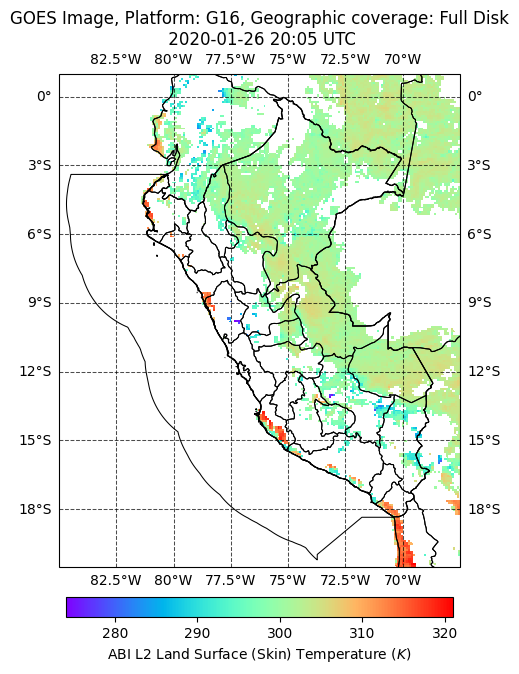

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=map_proj_dst[0]))
im = ax.pcolormesh(lon2D,lat2D,newdata.data,cmap=product_cmap,transform=map_proj_dst[0])
cbar = plt.colorbar(im,ax=ax, orientation='horizontal', shrink=0.5, pad=0.05)
units_latex = re.sub(r'(\w)(-)(\d)', r'\1^{-\3}', data[varname].units)
if ( selected_product[:-1] == "ABI-L1b-Rad") or (selected_product[:-1] == "ABI-L2-CMIP"):
    cbar.set_label(r"{} $({})$, band={}".format(data.title,units_latex,selected_channel))
else:
    cbar.set_label(r"{} $({})$".format(data.title,units_latex))
ax.set_extent(PeruLimits_deg)
ax.add_feature(coastlines_feature, linewidth=0.75)
ax.add_feature(countries_feature, linewidth=0.75)
ax.add_geometries(gdf_peru_land['geometry'], crs=map_proj_pc[0], facecolor='none', edgecolor='black', linewidth=0.75)
ax.add_geometries(gdf_peru_sea['geometry'], crs=map_proj_pc[0], facecolor='none', edgecolor='black', linewidth=0.75)
ax.gridlines(draw_labels=True,lw=0.75,color='k',alpha=0.7,ls='--')
ax.set_title("GOES Image, Platform: {}, Geographic coverage: {}\n {}".format(data.platform_ID,data.scene_id,str_ImgTime))
plt.show()

In [ ]:
from shapely.geometry import Point
# Create an array of Point objects using the meshgrid coordinates
points = [Point(lon, lat) for lon, lat in zip(lon2D.ravel(), lat2D.ravel())]
# Create a boolean mask indicating which points are inside the polygon
polygon = gdf_peru_land['geometry']
mergedPolys = unary_union(polygon)
points_inside_polygon_mask = np.array([mergedPolys.contains(point) for point in points])
# Reshape the mask to match the shape of the data array
points_inside_polygon_mask = points_inside_polygon_mask.reshape(lon2D.shape)

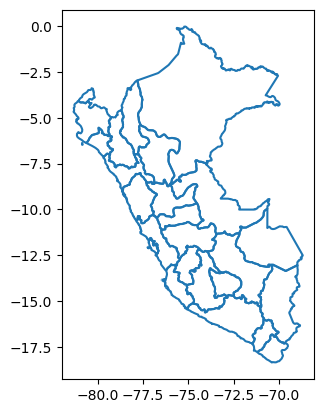

In [ ]:
gpd.GeoSeries(polygon).boundary.plot()
plt.show()

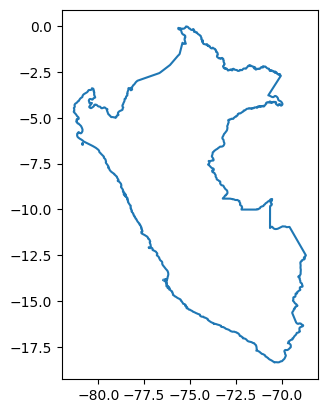

In [ ]:
from shapely.ops import unary_union

mergedPolys = unary_union(polygon)

gpd.GeoSeries([mergedPolys]).boundary.plot()
plt.show()

In [ ]:
# import matplotlib.pyplot as plt
import matplotlib.colors as mcolors
# import numpy as np

# Define the RGB values for your colormap
rgb_values = [
    [255, 255, 255],
    [127, 127, 127],
    [0, 200, 255],
    [0, 163, 255],
    [0, 82, 255],
    [0, 0, 200],
    [150, 255, 150],
    [50, 200, 50],
    [0, 130, 0],
    [255, 255, 0],
    [170, 170, 0],
    [255, 127, 0],
    [200, 70, 70],
    [255, 160, 160],
    [255, 0, 0],
    [157, 0, 157],
    [0, 0, 0],
    [222, 222, 222]]

# Normalize the RGB values to the range [0, 1]
norm = mcolors.Normalize(vmin=0, vmax=len(rgb_values) - 1)
colors = [tuple(rgb / 255.0 for rgb in rgb_value) for rgb_value in rgb_values]

# Create the colormap
rainfall_cmap = mcolors.ListedColormap(colors)

colormaps = {'ABI-L2-DSRF':'turbo','ABI-L2-ACMF':'rainbow','ABI-L2-TPWF':'terrain','ABI-L2-LSTF':'jet'}
colormaps['ABI-L2-RRQPEF'] = rainfall_cmap

In [ ]:
product_cmap = colormaps['ABI-L2-ACMF']

In [ ]:
def plotSatImg(L2Data):
    import matplotlib.pyplot as plt
    import cartopy.feature as cfeature

    if(coords == "xy"):
        fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=map_proj_dst[0]))
        ax.set_extent(PeruLimits_deg)
        # im = ax.imshow(transformed_data, origin='lower', transform=map_proj_dst[0], extent=extent_deg, cmap='turbo')
        im = ax.imshow(L2Data[varname].values, transform=map_proj_src[0], cmap=product_cmap)
        cbar = plt.colorbar(im,ax=ax, orientation='horizontal', shrink=0.5, pad=0.05)
        units_latex = re.sub(r'(\w)(-)(\d)', r'\1^{-\3}', L2Data[varname].units)
        if ( selected_product[:-1] == "ABI-L1b-Rad") or (selected_product[:-1] == "ABI-L2-CMIP"):
            cbar.set_label(r"{} $({})$, band={}".format(data.title,units_latex,selected_channel))
        else:
            cbar.set_label(r"{} $({})$".format(data.title,units_latex))
        ax.add_feature(coastlines_feature, linewidth=0.75)
        ax.add_feature(countries_feature, linewidth=0.75)
        ax.add_geometries(gdf_peru_land['geometry'], crs=map_proj_pc[0], facecolor='none', edgecolor='black', linewidth=0.75)
        ax.add_geometries(gdf_peru_sea['geometry'], crs=map_proj_pc[0], facecolor='none', edgecolor='black', linewidth=0.75)
        ax.gridlines(draw_labels=True,lw=0.75,color='k',alpha=0.7,ls='--')
        ax.set_title("GOES Image, Platform: {}, Geographic coverage: {}\n {}".format(data.platform_ID,data.scene_id,str_ImgTime))
        plt.show()
    elif(coords == "lonlat"):
        fig, ax = plt.subplots(figsize=(10, 8), subplot_kw=dict(projection=map_proj_src[0]))
        im = ax.pcolormesh(lon,lat,L2Data[varname].values,cmap=product_cmap,transform=map_proj_src[0])
        cbar = plt.colorbar(im,ax=ax, orientation='horizontal', shrink=0.5, pad=0.05)
        units_latex = re.sub(r'(\w)(-)(\d)', r'\1^{-\3}', L2Data[varname].units)
        if ( selected_product[:-1] == "ABI-L1b-Rad") or (selected_product[:-1] == "ABI-L2-CMIP"):
            cbar.set_label(r"{} $({})$, band={}".format(data.title,units_latex,selected_channel))
        else:
            cbar.set_label(r"{} $({})$".format(data.title,units_latex))
        ax.add_feature(coastlines_feature, linewidth=0.75)
        ax.add_feature(countries_feature, linewidth=0.75)
        ax.add_geometries(gdf_peru_land['geometry'], crs=map_proj_pc[0], facecolor='none', edgecolor='black', linewidth=0.75)
        ax.add_geometries(gdf_peru_sea['geometry'], crs=map_proj_pc[0], facecolor='none', edgecolor='black', linewidth=0.75)
        ax.gridlines(draw_labels=True,lw=0.75,color='k',alpha=0.7,ls='--')
        ax.set_title("GOES Image, Platform: {}, Geographic coverage: {}\n {}".format(data.platform_ID,data.scene_id,str_ImgTime))
        plt.show()
    ImageName = satellite +'_'+ year +'_'+ month +'_'+ day +'_'+ selected_product.split('-')[-1] +'_'+ hour +'_'+ minute + '.png'
    # plt.savefig(os.path.join(FilePath, ImageName),dpi=300,bbox_inches='tight')
    print("Image '{}' saved in '{}'".format(ImageName,FilePath))
    return

/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_physical/ne_50m_coastline.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)
/usr/local/lib/python3.10/dist-packages/cartopy/io/__init__.py:241: DownloadWarning: Downloading: https://naturalearth.s3.amazonaws.com/50m_cultural/ne_50m_admin_0_countries.zip
  warnings.warn(f'Downloading: {url}', DownloadWarning)


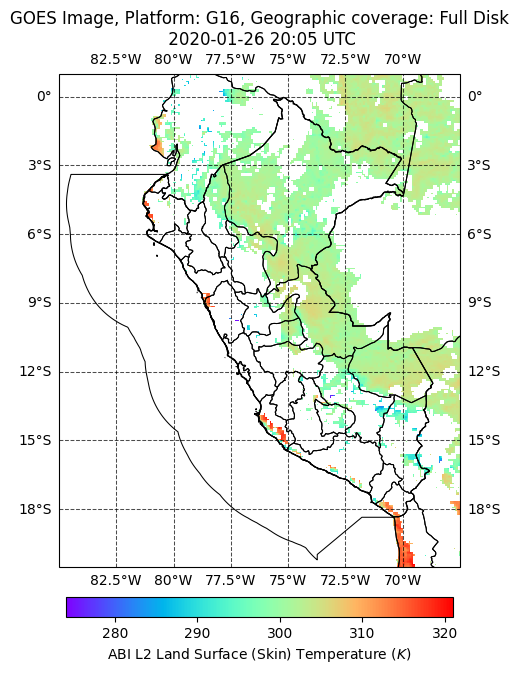

NameError: ignored

In [ ]:
plotSatImg(data)